In [ ]:
import kagglehub

# Download the selected version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset/versions/1")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/the-wildfire-dataset


In [ ]:
import shutil

# Copy the dataset to a writable directory
writable_path = "/kaggle/working/MobileViT_Variant_A"
shutil.copytree(path, writable_path)


'/kaggle/working/MobileViT_Variant_A'

In [ ]:
!rm /kaggle/working/MobileViT_Variant_A/the_wildfire_dataset/the_wildfire_dataset/val/fire/Both_smoke_and_fire/desktop.ini

In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from transformers import MobileViTForImageClassification, MobileViTImageProcessor

In [ ]:
# Use pretrained weights
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

In [ ]:
# Fire vs No Fire
in_features = model.classifier.in_features

# Strip out original classifier
model.classifier = nn.Identity()

# Binary Head
binary_head = nn.Sequential(
    nn.Linear(in_features, 1),
    nn.Sigmoid()
)

# Multi-class Head -> 5 output classes
multi_class_head = nn.Linear(in_features, 5)

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomFireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.binary_labels = []
        self.multi_class_labels = []

        # Define mappings for binary and multi-class labels
        binary_label_mapping = {'fire': 1, 'nofire': 0}
        multi_class_mapping = {
            'fire': {'Both_smoke_and_fire': 0, 'Smoke_from_fires': 1},
            'nofire': {'Fire_confounding_elements': 2, 'Forested_areas_without_confounding_elements': 3, 'Smoke_confounding_elements': 4}
        }

        # Traverse the root directory and collect image paths and labels
        for binary_label_name in os.listdir(root_dir):
            binary_label_path = os.path.join(root_dir, binary_label_name)
            if os.path.isdir(binary_label_path):
                # Assign binary label
                binary_label = binary_label_mapping[binary_label_name]

                # Traverse subclasses
                for subclass_name in os.listdir(binary_label_path):
                    subclass_path = os.path.join(binary_label_path, subclass_name)
                    if os.path.isdir(subclass_path):
                        # Assign multi-class label
                        multi_class_label = multi_class_mapping[binary_label_name][subclass_name]

                        # Collect all images in the subclass directory
                        for img_name in os.listdir(subclass_path):
                            img_path = os.path.join(subclass_path, img_name)
                            if os.path.isfile(img_path):
                                self.image_paths.append(img_path)
                                self.binary_labels.append(binary_label)
                                self.multi_class_labels.append(multi_class_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        binary_label = self.binary_labels[idx]
        multi_class_label = self.multi_class_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, (torch.tensor(binary_label, dtype=torch.float), torch.tensor(multi_class_label, dtype=torch.long))


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your datasets (replace "path_to_train_dataset" and "path_to_val_dataset" with your paths)
#train_dataset = datasets.ImageFolder("/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version/train", transform=train_transforms)
#val_dataset = datasets.ImageFolder("/root/.cache/kagglehub/datasets/elmadafri/the-wildfire-dataset/versions/3/the_wildfire_dataset_2n_version/val", transform=val_transforms)
train_dataset = CustomFireDataset(root_dir="/kaggle/working/MobileViT_Variant_A/the_wildfire_dataset/the_wildfire_dataset/train", transform=train_transforms)
val_dataset = CustomFireDataset(root_dir="/kaggle/working/MobileViT_Variant_A/the_wildfire_dataset/the_wildfire_dataset/val", transform=val_transforms)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=10)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
criterion_binary = nn.BCELoss()
criterion_multi_class = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(binary_head.parameters()) + list(multi_class_head.parameters()),
    lr=0.001
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
binary_head = binary_head.to(device)
multi_class_head = multi_class_head.to(device)

In [ ]:
def combined_loss(binary_output, binary_target, multi_class_output, multi_class_target, alpha=0.5, beta=0.5):
    loss_binary = criterion_binary(binary_output, binary_target)
    loss_multi_class = criterion_multi_class(multi_class_output, multi_class_target)
    return alpha * loss_binary + beta * loss_multi_class

In [ ]:
epoch_list = []
loss_list = []
train_binary_accuracy_list = []
train_multi_class_accuracy_list = []
val_binary_accuracy_list = []
val_multi_class_accuracy_list = []

# Training loop
epochs = 30  # You can adjust the number of epochs based on your needs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train_binary = 0
    total_train_binary = 0
    correct_train_multi_class = 0
    total_train_multi_class = 0

    # Training Loop
    for images, (binary_labels, multi_class_labels) in train_loader:
        images = images.to(device)
        binary_labels = binary_labels.to(device).float()
        multi_class_labels = multi_class_labels.to(device).long()

        optimizer.zero_grad()
        features = model(images)  # Extract features using MobileViT
        features = features.logits
        binary_output = binary_head(features)
        multi_class_output = multi_class_head(features)

        # Compute the combined loss
        loss = combined_loss(binary_output.squeeze(), binary_labels, multi_class_output, multi_class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for binary classification
        predicted_binary = (binary_output.squeeze() > 0.5).int()  # Convert probabilities to binary predictions
        correct_train_binary += (predicted_binary == binary_labels.int()).sum().item()
        total_train_binary += binary_labels.size(0)

        # Calculate training accuracy for multi-class classification
        _, predicted_multi_class = torch.max(multi_class_output, 1)
        correct_train_multi_class += (predicted_multi_class == multi_class_labels).sum().item()
        total_train_multi_class += multi_class_labels.size(0)

    # Calculate the average loss and training accuracies
    avg_loss = running_loss / len(train_loader)
    train_binary_accuracy = 100 * correct_train_binary / total_train_binary
    train_multi_class_accuracy = 100 * correct_train_multi_class / total_train_multi_class

    # Validation Loop
    model.eval()
    correct_val_binary = 0
    total_val_binary = 0
    correct_val_multi_class = 0
    total_val_multi_class = 0
    with torch.no_grad():
        for images, (binary_labels, multi_class_labels) in val_loader:
            images = images.to(device)
            binary_labels = binary_labels.to(device).float()
            multi_class_labels = multi_class_labels.to(device).long()

            features = model(images)  # Extract features using MobileNetV3
            features = features.logits
            binary_output = binary_head(features)
            multi_class_output = multi_class_head(features)

            # Calculate validation accuracy for binary classification
            predicted_binary = (binary_output.squeeze() > 0.5).int()
            correct_val_binary += (predicted_binary == binary_labels.int()).sum().item()
            total_val_binary += binary_labels.size(0)

            # Calculate validation accuracy for multi-class classification
            _, predicted_multi_class = torch.max(multi_class_output, 1)
            correct_val_multi_class += (predicted_multi_class == multi_class_labels).sum().item()
            total_val_multi_class += multi_class_labels.size(0)

    # Calculate validation accuracies
    val_binary_accuracy = 100 * correct_val_binary / total_val_binary
    val_multi_class_accuracy = 100 * correct_val_multi_class / total_val_multi_class

    # Store the metrics
    epoch_list.append(epoch + 1)
    loss_list.append(avg_loss)
    train_binary_accuracy_list.append(train_binary_accuracy)
    train_multi_class_accuracy_list.append(train_multi_class_accuracy)
    val_binary_accuracy_list.append(val_binary_accuracy)
    val_multi_class_accuracy_list.append(val_multi_class_accuracy)

    # Log the metrics
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Training Binary Accuracy: {train_binary_accuracy:.2f}%")
    print(f"  Training Multi-Class Accuracy: {train_multi_class_accuracy:.2f}%")
    print(f"  Validation Binary Accuracy: {val_binary_accuracy:.2f}%")
    print(f"  Validation Multi-Class Accuracy: {val_multi_class_accuracy:.2f}%")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarn

Epoch 1/30
  Loss: 0.1875
  Training Binary Accuracy: 97.35%
  Training Multi-Class Accuracy: 89.61%
  Validation Binary Accuracy: 89.55%
  Validation Multi-Class Accuracy: 79.10%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2/30
  Loss: 0.1797
  Training Binary Accuracy: 97.88%
  Training Multi-Class Accuracy: 90.78%
  Validation Binary Accuracy: 93.78%
  Validation Multi-Class Accuracy: 82.09%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3/30
  Loss: 0.1280
  Training Binary Accuracy: 98.36%
  Training Multi-Class Accuracy: 93.27%
  Validation Binary Accuracy: 84.33%
  Validation Multi-Class Accuracy: 72.64%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4/30
  Loss: 0.1318
  Training Binary Accuracy: 98.46%
  Training Multi-Class Accuracy: 92.42%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 79.10%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5/30
  Loss: 0.1346
  Training Binary Accuracy: 98.20%
  Training Multi-Class Accuracy: 92.47%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 80.10%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6/30
  Loss: 0.1377
  Training Binary Accuracy: 97.40%
  Training Multi-Class Accuracy: 92.47%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 80.60%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7/30
  Loss: 0.1066
  Training Binary Accuracy: 98.52%
  Training Multi-Class Accuracy: 94.12%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 77.61%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8/30
  Loss: 0.0721
  Training Binary Accuracy: 99.47%
  Training Multi-Class Accuracy: 95.81%
  Validation Binary Accuracy: 92.54%
  Validation Multi-Class Accuracy: 80.85%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9/30
  Loss: 0.0616
  Training Binary Accuracy: 99.21%
  Training Multi-Class Accuracy: 96.50%
  Validation Binary Accuracy: 87.81%
  Validation Multi-Class Accuracy: 79.60%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10/30
  Loss: 0.1243
  Training Binary Accuracy: 97.62%
  Training Multi-Class Accuracy: 94.01%
  Validation Binary Accuracy: 94.53%
  Validation Multi-Class Accuracy: 82.34%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11/30
  Loss: 0.0897
  Training Binary Accuracy: 98.68%
  Training Multi-Class Accuracy: 95.23%
  Validation Binary Accuracy: 92.29%
  Validation Multi-Class Accuracy: 81.59%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12/30
  Loss: 0.0617
  Training Binary Accuracy: 99.79%
  Training Multi-Class Accuracy: 96.08%
  Validation Binary Accuracy: 94.03%
  Validation Multi-Class Accuracy: 83.83%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13/30
  Loss: 0.0577
  Training Binary Accuracy: 99.15%
  Training Multi-Class Accuracy: 97.03%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 80.85%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14/30
  Loss: 0.0614
  Training Binary Accuracy: 99.05%
  Training Multi-Class Accuracy: 97.24%
  Validation Binary Accuracy: 92.29%
  Validation Multi-Class Accuracy: 79.10%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15/30
  Loss: 0.0861
  Training Binary Accuracy: 98.78%
  Training Multi-Class Accuracy: 95.44%
  Validation Binary Accuracy: 91.29%
  Validation Multi-Class Accuracy: 79.60%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16/30
  Loss: 0.0976
  Training Binary Accuracy: 98.46%
  Training Multi-Class Accuracy: 94.12%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 78.86%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17/30
  Loss: 0.0439
  Training Binary Accuracy: 99.68%
  Training Multi-Class Accuracy: 97.93%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 82.34%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18/30
  Loss: 0.0238
  Training Binary Accuracy: 99.84%
  Training Multi-Class Accuracy: 98.41%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 81.59%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19/30
  Loss: 0.0343
  Training Binary Accuracy: 99.58%
  Training Multi-Class Accuracy: 97.99%
  Validation Binary Accuracy: 93.78%
  Validation Multi-Class Accuracy: 82.09%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20/30
  Loss: 0.0481
  Training Binary Accuracy: 99.63%
  Training Multi-Class Accuracy: 96.82%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 83.08%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21/30
  Loss: 0.0381
  Training Binary Accuracy: 99.63%
  Training Multi-Class Accuracy: 97.83%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 81.59%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22/30
  Loss: 0.0581
  Training Binary Accuracy: 99.21%
  Training Multi-Class Accuracy: 97.19%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 76.87%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23/30
  Loss: 0.0542
  Training Binary Accuracy: 98.94%
  Training Multi-Class Accuracy: 97.30%
  Validation Binary Accuracy: 92.04%
  Validation Multi-Class Accuracy: 79.35%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24/30
  Loss: 0.0361
  Training Binary Accuracy: 99.74%
  Training Multi-Class Accuracy: 97.93%
  Validation Binary Accuracy: 93.28%
  Validation Multi-Class Accuracy: 84.33%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25/30
  Loss: 0.0646
  Training Binary Accuracy: 99.05%
  Training Multi-Class Accuracy: 97.35%
  Validation Binary Accuracy: 92.54%
  Validation Multi-Class Accuracy: 78.86%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26/30
  Loss: 0.0883
  Training Binary Accuracy: 98.83%
  Training Multi-Class Accuracy: 95.87%
  Validation Binary Accuracy: 92.54%
  Validation Multi-Class Accuracy: 79.35%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27/30
  Loss: 0.0577
  Training Binary Accuracy: 99.05%
  Training Multi-Class Accuracy: 96.82%
  Validation Binary Accuracy: 92.79%
  Validation Multi-Class Accuracy: 81.34%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28/30
  Loss: 0.0553
  Training Binary Accuracy: 98.83%
  Training Multi-Class Accuracy: 97.24%
  Validation Binary Accuracy: 93.28%
  Validation Multi-Class Accuracy: 81.84%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29/30
  Loss: 0.0313
  Training Binary Accuracy: 99.68%
  Training Multi-Class Accuracy: 98.41%
  Validation Binary Accuracy: 93.03%
  Validation Multi-Class Accuracy: 81.09%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30/30
  Loss: 0.0316
  Training Binary Accuracy: 99.52%
  Training Multi-Class Accuracy: 97.99%
  Validation Binary Accuracy: 93.03%
  Validation Multi-Class Accuracy: 81.34%


In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), "mobileVit_fire_multi_classifier_Variant_A.pth")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Save the metrics to a CSV file
data = {
    'Epoch': epoch_list,
    'Loss': loss_list,
    'Train Binary Accuracy': train_binary_accuracy_list,
    'Train Multi-Class Accuracy': train_multi_class_accuracy_list,
    'Validation Binary Accuracy': val_binary_accuracy_list,
    'Validation Multi-Class Accuracy': val_multi_class_accuracy_list
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('multi_training_results.csv', index=False)
print("Training results saved to 'training_results.csv' successfully!")

Training results saved to 'training_results.csv' successfully!


In [ ]:
# Define transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your test dataset
test_dataset = CustomFireDataset(root_dir="/kaggle/working/MobileViT_Variant_A/the_wildfire_dataset/the_wildfire_dataset/test", transform=test_transforms)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10)

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import torch

# Lists to store true labels and predicted probabilities/scores for binary classification
true_binary_labels = []
predicted_binary_probs = []  # Probabilities for the positive class (fire)

# Lists to store true labels and predicted labels for multi-class classification
true_multi_class_labels = []
predicted_multi_class_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, (binary_labels, multi_class_labels) in test_loader:
        images = images.to(device)
        binary_labels = binary_labels.to(device).float()
        multi_class_labels = multi_class_labels.to(device).long()

        # Forward pass
        features = model(images)
        features = features.logits
        binary_output = binary_head(features)
        multi_class_output = multi_class_head(features)

        # Get probabilities for the positive class (fire) in binary classification
        binary_probs = binary_output.squeeze().cpu().numpy()  # Probabilities from Sigmoid

        # Get predicted class labels for multi-class classification
        _, predicted_multi_class = torch.max(multi_class_output, 1)
        predicted_multi_class = predicted_multi_class.cpu().numpy()

        # Store true labels and predictions for binary classification
        true_binary_labels.extend(binary_labels.cpu().numpy())
        predicted_binary_probs.extend(binary_probs)

        # Store true labels and predictions for multi-class classification
        true_multi_class_labels.extend(multi_class_labels.cpu().numpy())
        predicted_multi_class_labels.extend(predicted_multi_class)

# Combine all data into a single DataFrame
data = pd.DataFrame({
    "True Binary Labels": true_binary_labels,
    "Predicted Binary Probabilities": predicted_binary_probs,
    "True Multi-Class Labels": true_multi_class_labels,
    "Predicted Multi-Class Labels": predicted_multi_class_labels
})

data.to_csv("mtl_mobileVit_VariantA_test_results.csv", index=False)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report

# Load the data
data = pd.read_csv("mtl_mobileVit_VariantA_test_results.csv")

# Binary Classification Metrics
true_binary = np.array(data['True Binary Labels'])
pred_binary_probs = np.array(data['Predicted Binary Probabilities'])
pred_binary = (pred_binary_probs >= 0.5).astype(int)

f1 = f1_score(true_binary, pred_binary)
precision = precision_score(true_binary, pred_binary)
recall = recall_score(true_binary, pred_binary)
accuracy = accuracy_score(true_binary, pred_binary)
roc_auc = roc_auc_score(true_binary, pred_binary_probs)

print("Binary Classification Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Multi-class Classification Metrics
true_multi = np.array(data['True Multi-Class Labels'])
pred_multi = np.array(data['Predicted Multi-Class Labels'])

print("\nMulti-class Classification Report:")
print(classification_report(true_multi, pred_multi))

Binary Classification Metrics:
F1 Score: 0.9274
Precision: 0.9304
Recall: 0.9245
Accuracy: 0.9439
ROC-AUC: 0.9894

Multi-class Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.78        59
           1       0.77      0.90      0.83       100
           2       0.81      0.73      0.77        52
           3       0.86      0.93      0.89       128
           4       0.82      0.75      0.78        71

    accuracy                           0.83       410
   macro avg       0.84      0.80      0.81       410
weighted avg       0.83      0.83      0.83       410



In [ ]:
import pandas as pd
import matplotlib as plt

In [ ]:
training_results = pd.read_csv("multi_training_results.csv", index_col=False)

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(data, epochs_col, train_binary_col, train_multiclass_col, val_binary_col, val_multiclass_col):
    """
    Plots the training and validation accuracies over epochs.

    Parameters:
        data (DataFrame): The data containing the accuracies and epochs.
        epochs_col (str): Column name for the epochs.
        train_binary_col (str): Column name for training binary accuracy.
        train_multiclass_col (str): Column name for training multi-class accuracy.
        val_binary_col (str): Column name for validation binary accuracy.
        val_multiclass_col (str): Column name for validation multi-class accuracy.
    """
    # Extract data
    epochs = data[epochs_col]
    train_binary_acc = data[train_binary_col]
    train_multiclass_acc = data[train_multiclass_col]
    val_binary_acc = data[val_binary_col]
    val_multiclass_acc = data[val_multiclass_col]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_binary_acc, label="Train Binary Accuracy", marker='o')
    plt.plot(epochs, train_multiclass_acc, label="Train Multi-Class Accuracy", marker='x')
    plt.plot(epochs, val_binary_acc, label="Validation Binary Accuracy", marker='o')
    plt.plot(epochs, val_multiclass_acc, label="Validation Multi-Class Accuracy", marker='x')

    # Add title and labels
    plt.title("MobileViT - Accuracies Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


In [ ]:
def plot_loss(data, epochs_col, loss_col):
    """
    Plots the loss over epochs.

    Parameters:
        data (DataFrame): The data containing the loss values and epochs.
        epochs_col (str): Column name for the epochs.
        loss_col (str): Column name for the loss values.
    """
    # Extract data
    epochs = data[epochs_col]
    loss = data[loss_col]

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label="Loss", marker='o', color='red')

    # Add title and labels
    plt.title("MobileViT - Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

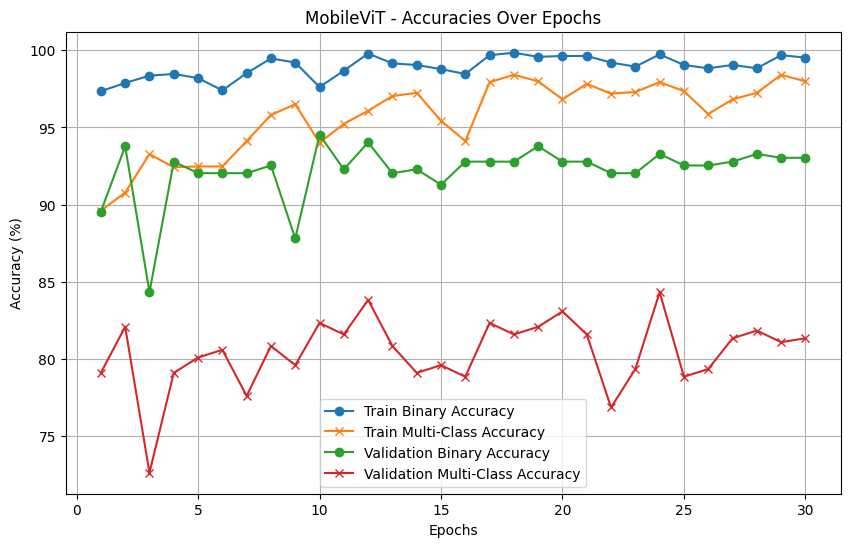

In [ ]:
plot_accuracies(
    data=training_results,
    epochs_col='Epoch',
    train_binary_col='Train Binary Accuracy',
    train_multiclass_col='Train Multi-Class Accuracy',
    val_binary_col='Validation Binary Accuracy',
    val_multiclass_col='Validation Multi-Class Accuracy'
)